In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize,root
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [10]:
class MLE:
    def __init__(self,dim,sigma):
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.iP=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim),cov=sigma**2)
        self.iS=lambda size: mvnorm.rvs(size=size,mean=np.zeros(dim),cov=sigma**2)
        
    def __estimate(self,W,name,asym=True):
        Z=np.mean(W)
        err=np.abs(Z-1)
        if asym:
            aVar=np.var(W)
            aErr=np.sqrt(aVar/W.size)
            ESS=1/np.sum((W/np.sum(W))**2)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}; ESS: {:.0f}/{}'\
                  .format(name,Z,err,aVar,aErr,ESS,W.size))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,Z,err))
        
    def estimate_IS(self,size):
        S=self.iS(size)
        W=self.T(S)/self.iP(S)
        self.__estimate(W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        ratio=np.reshape(self.T(np.zeros(self.dim))/P(np.zeros([1,self.dim])),1)[0]
        print('------------ pdf ratio at origin: {:.2f} ------------'.format(ratio))
        
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])
            rW=rW/rW.max()*P(np.zeros([1,self.dim]))[0]
            rWmeans=np.ones_like(rW)*rW.mean()

            ax.plot(x,self.mP(X))
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rWmeans)
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rW)
            ax.legend(['target','nonparametric proposal','mixture proposal','centers','centers with weight'])
        elif name=='regression':
            G=self.G(X)
            rPO=self.regO.coef_.dot(G)+self.regO.intercept_*P(X)
            rPL=self.regL.coef_.dot(G)+self.regL.intercept_*P(X)
            mid=int(x.size/2)
            print('regression ratios: ordinary {:.4f}, lasso {:.4f}'\
                  .format(self.T(X[mid])/rPO[mid],self.T(X[mid])/rPL[mid]))
            
            ax.plot(x,rPO)
            ax.plot(x,rPL)
            ax.legend(['target','mixture proposal','ordinary regression','lasso regression'])
        else:
            ax.legend(['target','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.T(S)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resampling rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,size,rate,bdwth='scott',reg=0):
        if(type(bdwth)==str):
            method=bdwth
            tmp=sciKDE(self.rS.T,bw_method=method)
            bdwth=np.mean(np.sqrt(np.diag(tmp.covariance_factor()*np.cov(self.rS.T))))
            print('bdwth: {:.4f} (based on {})'.format(bdwth,method))
        
        self.bdwth=bdwth
        self.kde=sklKDE(kernel='gaussian',bandwidth=bdwth).fit(self.rS)
        self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=self.bdwth**2)
        if reg==0:
            self.G=lambda x: np.array([self.h(x,loc) for loc in self.rSset])-self.iP(x)
        elif reg==1:
            self.G=lambda x: np.array([self.h(x,self.rSset[i])-self.h(x,self.rSset[0])\
                                       for i in range(1,self.rSset.shape[0])])
        elif reg==2:
            self.G=lambda x: np.array([self.h(x,self.rSset[i])-self.h(x,self.rSset[i-1])\
                                       for i in range(1,self.rSset.shape[0])])
        elif reg==3:
            def G(x):
                tmp=np.array([self.h(x,loc) for loc in self.rSset])
                return tmp[1:]-tmp.mean(axis=0)
                
            self.G=G
        
        self.nP=lambda x: np.exp(self.kde.score_samples(x))
        self.nS=lambda size: self.kde.sample(size)
        S=self.nS(size)
        W=self.T(S)/self.nP(S)
        self.__estimate(W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        self.S=self.mS(size)
        W=self.T(self.S)/self.mP(self.S)
        self.__estimate(W,'MIS')
        
    def estimate_RIS(self,alpha,vif=False):
        X=(self.G(self.S)/self.mP(self.S)).T
        if vif:
            if X.shape[1]<=100:
                ind=np.arange(X.shape[1])
            else:
                ind=np.random.choice(np.arange(X.shape[1]),100,replace=False)

            tmp=np.hstack([X,np.ones([X.shape[0],1])])
            Vif=np.zeros(ind.size)
            for i in range(ind.size):
                Vif[i]=VIF(tmp,ind[i])

            print('VIF: (min {:.4f}, median {:.4f}, mean {:.4f}, max {:.4f}, [>5] {}/{})'\
                  .format(Vif.min(),np.median(Vif),Vif.mean(),Vif.max(),np.sum(Vif>5),Vif.size))
            
        Xn=X/np.linalg.norm(X,axis=0)
        lbd=np.linalg.eigvals(Xn.T.dot(Xn))
        tau=np.sqrt(lbd.max()/lbd)
        print('Condition index: (min {:.4f}, median {:.4f}, mean {:.4f}, max {:.4f}, [>30] {}/{})'\
              .format(tau.min(),np.median(tau),tau.mean(),tau.max(),np.sum(tau>30),tau.size))
        
        y=self.T(self.S)/self.mP(self.S)
        self.regO=Linear().fit(X,y)
        self.regL=Lasso(alpha).fit(X,y)
        print('Ordinary R2: {:.4f}; Lasso R2: {:.4f}'.format(self.regO.score(X,y),self.regL.score(X,y)))
        
        W=y-X.dot(self.regO.coef_)
        self.__estimate(W,'RIS(Ord)')
        W=y-X.dot(self.regL.coef_)
        self.__estimate(W,'RIS(Las)')
    
    def estimate_MLE(self,opt=False,init=0):
        mP=self.mP(self.S)
        G=self.G(self.S)
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        hessian=lambda zeta: (G/(mP+zeta.dot(G))**2).dot(G.T)/G.shape[1]
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('Reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T(self.S)/mP)*(1-XX.dot(zeta1))
        self.__estimate(W,'RIS(The)',asym=False)
        W=self.T(self.S)/(mP+zeta1.dot(G))
        self.__estimate(W,'MLE(The)',asym=False)
        
        if opt:
            zeta=zeta1 if init==1 else zeta0
            begin=dt.now()
            res=root(lambda zeta: (gradient(zeta),hessian(zeta)),zeta,method='lm',jac=True)
            end=dt.now()
            print()
            print('Optimization results (spent {} seconds):'.format((end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T(self.S)/(mP+zeta.dot(G))
                self.__estimate(W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

**Limitations:**
1. didn't consider self-normalized importance sampling
2. only for symmetric normal target and symmetric normal initial proposal with only one mode
3. only for normal KDE without weights and adaptive bandwidth
4. only consider regression for proposal components based on mixture proposal

# Run the experiments

## Initial proposal and the curse of dimensionality

IS est: 1.0005; err: 0.0005; a-var: 1.2863; a-err: 0.0011; ESS: 437648/1000000
------------ pdf ratio at origin: 4.00 ------------


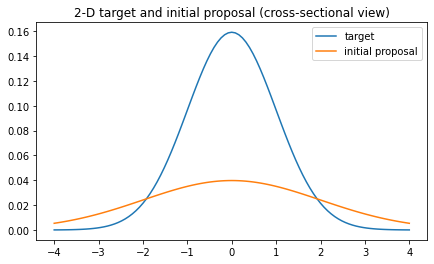

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS est: 1.0016; err: 0.0016; a-var: 4.2286; a-err: 0.0021; ESS: 191761/1000000
------------ pdf ratio at origin: 16.00 ------------


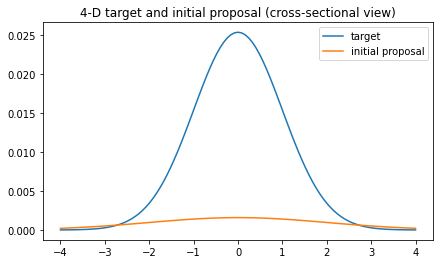

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS est: 0.9977; err: 0.0023; a-var: 26.1843; a-err: 0.0051; ESS: 36625/1000000
------------ pdf ratio at origin: 256.00 ------------


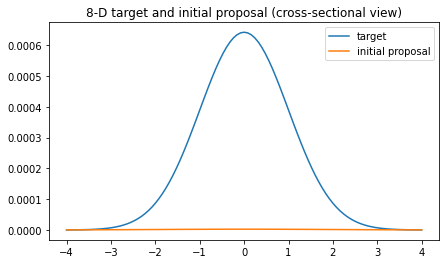

In [3]:
mle=MLE(dim=2,sigma=2)
size=1000000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

mle=MLE(dim=4,sigma=2)
mle.estimate_IS(size)
mle.draw_TP(mle.iP,x,'initial')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

mle=MLE(dim=8,sigma=2)
mle.estimate_IS(size)
mle.draw_TP(mle.iP,x,'initial')

**Summary:**
* The cumulative phenomenon of scale difference of all dimension. 

**Future:**
* What about the comparison between multi-normal and multi-t? 

## KDE with different initial proposal and bandwidth in 6-dimension

IS est: 1.0000; err: 0.0000; a-var: 0.0000; a-err: 0.0000; ESS: 50000/50000
------------ pdf ratio at origin: 1.00 ------------


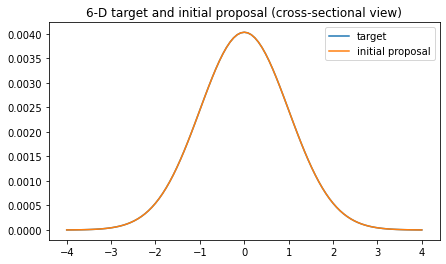

resampling rate: 968/1000
bdwth: 0.7112 (based on scott)
NIS est: 1.0043; err: 0.0043; a-var: 0.5006; a-err: 0.0032; ESS: 33416/50000
MIS est: 0.9996; err: 0.0004; a-var: 0.3878; a-err: 0.0028; ESS: 36018/50000
------------ pdf ratio at origin: 3.43 ------------


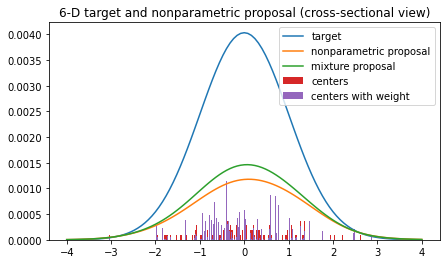

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS est: 0.9887; err: 0.0113; a-var: 10.9593; a-err: 0.0148; ESS: 4094/50000
------------ pdf ratio at origin: 64.00 ------------


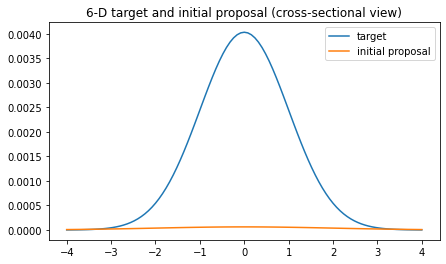

resampling rate: 771/1000
bdwth: 0.6959 (based on scott)
NIS est: 0.9992; err: 0.0008; a-var: 0.4291; a-err: 0.0029; ESS: 34970/50000
MIS est: 0.9999; err: 0.0001; a-var: 0.5573; a-err: 0.0033; ESS: 32106/50000
------------ pdf ratio at origin: 3.28 ------------


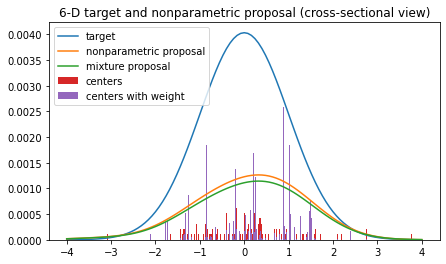

In [4]:
np.random.seed(1234)
mle=MLE(dim=6,sigma=1)
size=50000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

np.random.seed(1234)
mle=MLE(dim=6,sigma=2)
mle.estimate_IS(size)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,20)
np.random.seed(123456)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')

NIS est: 0.9986; err: 0.0014; a-var: 0.3562; a-err: 0.0027; ESS: 36840/50000
MIS est: 1.0006; err: 0.0006; a-var: 0.4574; a-err: 0.0030; ESS: 34322/50000
------------ pdf ratio at origin: 2.70 ------------


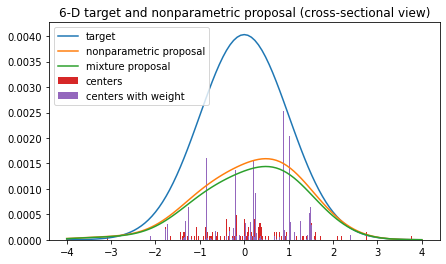

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
NIS est: 0.9958; err: 0.0042; a-var: 0.5727; a-err: 0.0034; ESS: 31695/50000
MIS est: 1.0019; err: 0.0019; a-var: 0.5562; a-err: 0.0033; ESS: 32172/50000
------------ pdf ratio at origin: 2.44 ------------


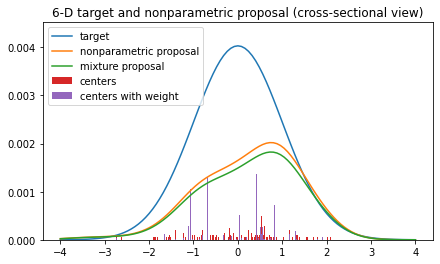

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
NIS est: 0.9853; err: 0.0147; a-var: 2.7418; a-err: 0.0074; ESS: 13075/50000
MIS est: 1.0017; err: 0.0017; a-var: 1.3382; a-err: 0.0052; ESS: 21426/50000
------------ pdf ratio at origin: 2.88 ------------


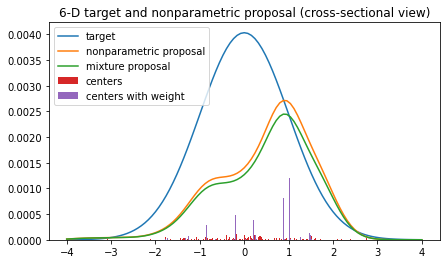

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
NIS est: 0.9853; err: 0.0147; a-var: 2.7418; a-err: 0.0074; ESS: 13075/50000
MIS est: 0.9963; err: 0.0037; a-var: 1.2414; a-err: 0.0050; ESS: 22216/50000
------------ pdf ratio at origin: 2.88 ------------


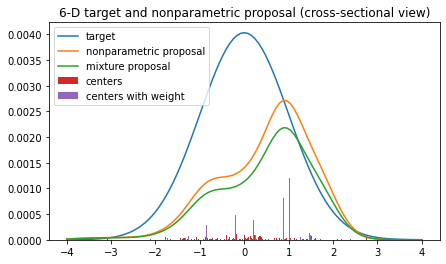

In [5]:
np.random.seed(123456)
mle.estimate_NIS(size,0.9,0.6)
mle.draw_TP(mle.nP,x,'nonparametric')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

np.random.seed(123456)
mle.estimate_NIS(size,0.9,0.5)
mle.draw_TP(mle.nP,x,'nonparametric')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

np.random.seed(123456)
mle.estimate_NIS(size,0.9,0.4)
mle.draw_TP(mle.nP,x,'nonparametric')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

np.random.seed(123456)
mle.estimate_NIS(size,0.8,0.4)
mle.draw_TP(mle.nP,x,'nonparametric')

**Summary:**
* Resampling ratio 20:1 can give us good 'samples' from the target. (We can increase it for better resample rate in higher dimension. )
* Only conservative bandwidth can work well in higher dimension, because little bandwidth can raise serious tail problem. 

**Future**
* What about KDE with weights? 
* What about the adaptive bandwidth? 

## Regression performance visualization

IS est: 0.9843; err: 0.0157; a-var: 25.4115; a-err: 0.0159; ESS: 3673/100000
------------ pdf ratio at origin: 256.00 ------------


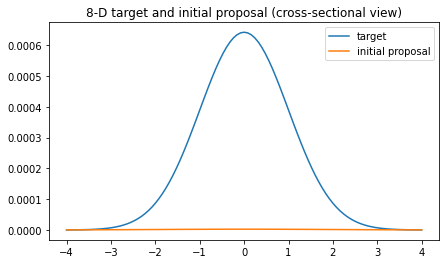

resampling rate: 658/1000
bdwth: 0.7489 (based on scott)
NIS est: 0.9961; err: 0.0039; a-var: 0.9840; a-err: 0.0031; ESS: 50206/100000
MIS est: 0.9913; err: 0.0087; a-var: 1.1729; a-err: 0.0034; ESS: 45587/100000
------------ pdf ratio at origin: 7.60 ------------


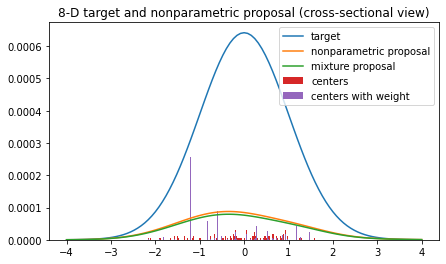

Ordinary R2: 0.7631; Lasso R2: 0.7285
RIS(Ord) est: 0.9974; err: 0.0026; a-var: 0.2779; a-err: 0.0017; ESS: 78163/100000
RIS(Las) est: 0.9970; err: 0.0030; a-var: 0.3184; a-err: 0.0018; ESS: 75741/100000
------------ pdf ratio at origin: 8.41 ------------
regression ratios: ordinary 1.7522, lasso 2.0118


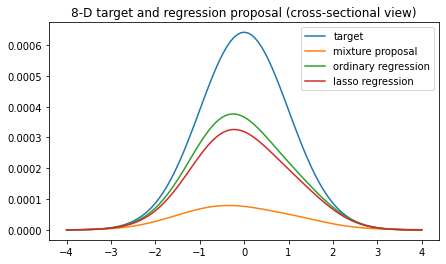

In [6]:
np.random.seed(1234)
mle=MLE(dim=8,sigma=2)
size=100000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')

IS est: 0.9942; err: 0.0058; a-var: 56.6618; a-err: 0.0238; ESS: 1714/100000
------------ pdf ratio at origin: 1024.00 ------------


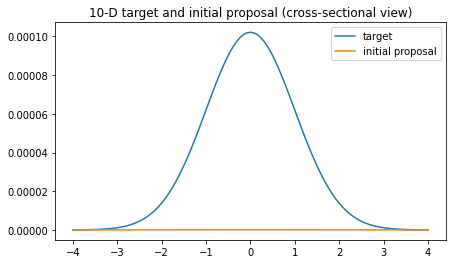

resampling rate: 528/1000
bdwth: 0.7822 (based on scott)
NIS est: 0.9979; err: 0.0021; a-var: 2.1075; a-err: 0.0046; ESS: 32088/100000
MIS est: 1.0029; err: 0.0029; a-var: 2.3833; a-err: 0.0049; ESS: 29679/100000
------------ pdf ratio at origin: 12.52 ------------


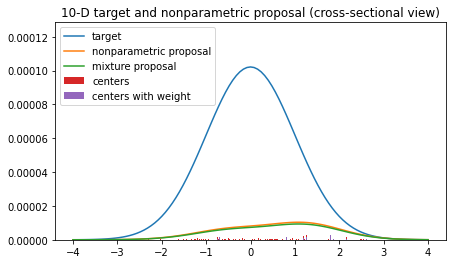

Ordinary R2: 0.3612; Lasso R2: 0.3514
RIS(Ord) est: 1.0018; err: 0.0018; a-var: 1.5223; a-err: 0.0039; ESS: 39734/100000
RIS(Las) est: 1.0024; err: 0.0024; a-var: 1.5458; a-err: 0.0039; ESS: 39395/100000
------------ pdf ratio at origin: 13.89 ------------
regression ratios: ordinary 2.9493, lasso 3.2017


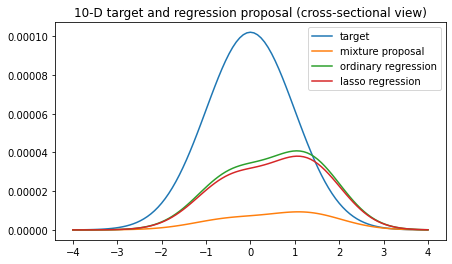

In [7]:
np.random.seed(1234)
mle=MLE(dim=10,sigma=2)
mle.estimate_IS(size)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
np.random.seed(123456)
mle.resample(1000,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')

resampling rate: 787/1000
bdwth: 0.7891 (based on scott)
NIS est: 0.9955; err: 0.0045; a-var: 1.5623; a-err: 0.0040; ESS: 38811/100000
MIS est: 1.0036; err: 0.0036; a-var: 1.8405; a-err: 0.0043; ESS: 35369/100000
------------ pdf ratio at origin: 12.95 ------------


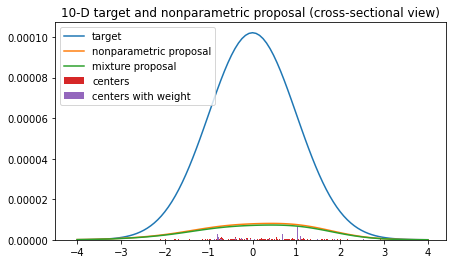

Ordinary R2: 0.6624; Lasso R2: 0.6469
RIS(Ord) est: 1.0038; err: 0.0038; a-var: 0.6213; a-err: 0.0025; ESS: 61856/100000
RIS(Las) est: 1.0038; err: 0.0038; a-var: 0.6499; a-err: 0.0025; ESS: 60789/100000
------------ pdf ratio at origin: 14.37 ------------
regression ratios: ordinary 2.5805, lasso 2.8181


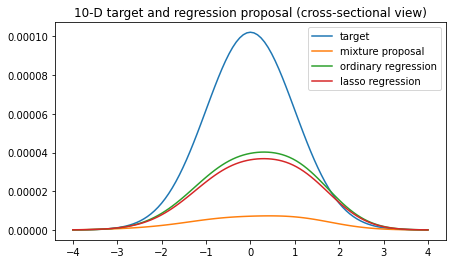

In [8]:
np.random.seed(123456)
mle.resample(1000,100)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')

**Summary:**
* Regression improve the estimation performance by mimic the shape of the target. 
* In higher dimension, improve the quality of kernels by increasing resampling ratio can slightly improve KDE but more dramatically improve regression. 

**Future**
* The problem of singularity? (What about multi-t initial? )
* What about regression for kernels not used in KDE? 
* What about regression with KDE with weights? 
* What about regression for kernels with adaptive bandwidth? (Will that improve the kernels' quality? )

## MLE method investigation

IS est: 0.9942; err: 0.0058; a-var: 56.6618; a-err: 0.0238; ESS: 1714/100000
------------ pdf ratio at origin: 1024.00 ------------


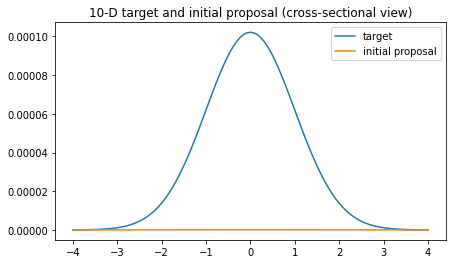

resampling rate: 807/1000
bdwth: 0.7771 (based on scott)
NIS est: 0.9997; err: 0.0003; a-var: 1.4875; a-err: 0.0039; ESS: 40185/100000
MIS est: 1.0062; err: 0.0062; a-var: 1.7917; a-err: 0.0042; ESS: 36108/100000
------------ pdf ratio at origin: 14.93 ------------


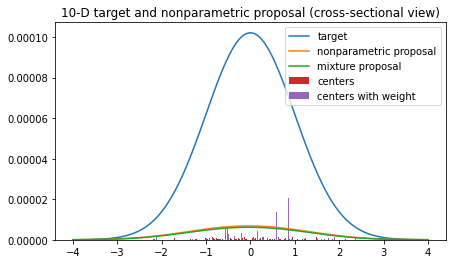

Ordinary R2: 0.6378; Lasso R2: 0.6217
RIS(Ord) est: 1.0037; err: 0.0037; a-var: 0.6490; a-err: 0.0025; ESS: 60819/100000
RIS(Las) est: 1.0040; err: 0.0040; a-var: 0.6777; a-err: 0.0026; ESS: 59798/100000
------------ pdf ratio at origin: 16.57 ------------
regression ratios: ordinary 3.0248, lasso 3.3007


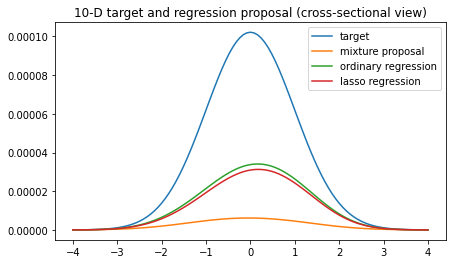

Reference:
origin: value: 16.8546; grad: (min -0.2099, mean 0.0004, max 0.2411, std 0.0579)

Theoretical results:
MLE(The) zeta: (min -0.0012, mean -0.0000, max 0.0011, std 0.0003, norm 0.0076)
theory: value: 16.8505; grad: (min -0.1732, mean -0.0076, max 0.0024, std 0.0150)
RIS(The) est: 1.0037; err: 0.0037
MLE(The) est: 1.0002; err: 0.0002

Optimization results (spent 15 seconds):
MLE(Opt) zeta: (min -0.0011, mean -0.0000, max 0.0011, std 0.0003, norm 0.0075)
Dist(zeta(Opt),zeta(The))=0.0010
optimal: value: 16.8503; grad: (min -0.0000, mean 0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 1.0021; err: 0.0021


In [9]:
np.random.seed(1234)
mle=MLE(dim=10,sigma=2)
size=100000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,100)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)

IS est: 1.0000; err: 0.0000; a-var: 0.0000; a-err: 0.0000; ESS: 100000/100000
------------ pdf ratio at origin: 1.00 ------------


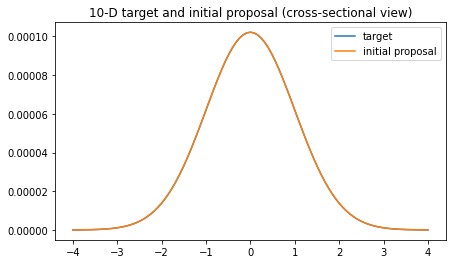

resampling rate: 993/1000
bdwth: 0.7879 (based on scott)
NIS est: 0.9956; err: 0.0044; a-var: 1.4793; a-err: 0.0038; ESS: 40120/100000
MIS est: 0.9989; err: 0.0011; a-var: 0.9886; a-err: 0.0031; ESS: 50231/100000
------------ pdf ratio at origin: 12.59 ------------


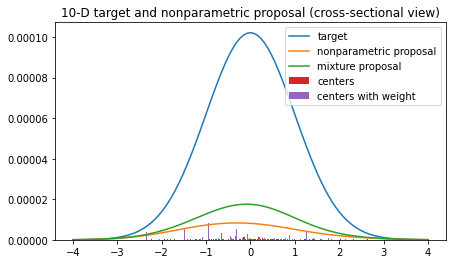

Ordinary R2: 1.0000; Lasso R2: 0.9849
RIS(Ord) est: 1.0000; err: 0.0000; a-var: 0.0000; a-err: 0.0000; ESS: 100000/100000
RIS(Las) est: 1.0003; err: 0.0003; a-var: 0.0149; a-err: 0.0004; ESS: 98530/100000
------------ pdf ratio at origin: 5.83 ------------
regression ratios: ordinary 1.0000, lasso 1.1625


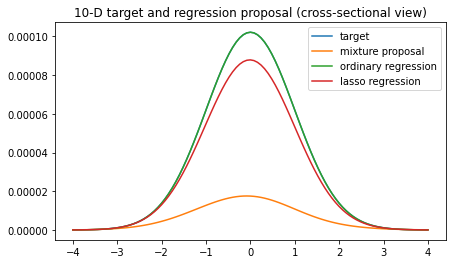

Reference:
origin: value: 16.1673; grad: (min -0.2649, mean -0.0011, max 0.2161, std 0.0543)

Theoretical results:
MLE(The) zeta: (min -0.0021, mean -0.0000, max 0.0016, std 0.0003, norm 0.0096)
theory: value: 16.1626; grad: (min -0.1648, mean -0.0055, max 0.0045, std 0.0121)
RIS(The) est: 1.0000; err: 0.0000
MLE(The) est: 0.9959; err: 0.0041

Optimization results (spent 19 seconds):
MLE(Opt) zeta: (min -0.0018, mean -0.0000, max 0.0017, std 0.0003, norm 0.0095)
Dist(zeta(Opt),zeta(The))=0.0014
optimal: value: 16.1624; grad: (min -0.0000, mean -0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 1.0000; err: 0.0000


In [10]:
np.random.seed(1234)
mle=MLE(dim=10,sigma=1)
mle.estimate_IS(size)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,100)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)

IS est: 0.9703; err: 0.0297; a-var: 6.6792; a-err: 0.0183; ESS: 2471/20000
------------ pdf ratio at origin: 32.00 ------------


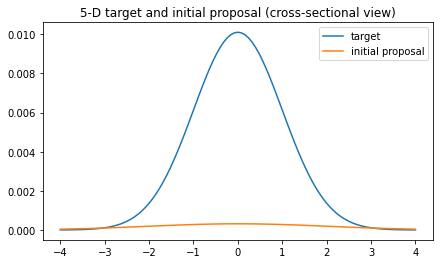

resampling rate: 963/1000
bdwth: 0.6736 (based on scott)
NIS est: 1.0040; err: 0.0040; a-var: 0.2847; a-err: 0.0038; ESS: 15595/20000
MIS est: 1.0024; err: 0.0024; a-var: 0.3866; a-err: 0.0044; ESS: 14443/20000
------------ pdf ratio at origin: 2.34 ------------


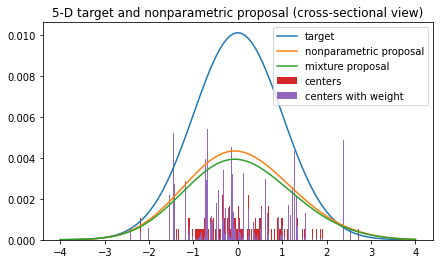

Ordinary R2: 0.9973; Lasso R2: 0.9411
RIS(Ord) est: 1.0005; err: 0.0005; a-var: 0.0010; a-err: 0.0002; ESS: 19979/20000
RIS(Las) est: 1.0003; err: 0.0003; a-var: 0.0228; a-err: 0.0011; ESS: 19555/20000
------------ pdf ratio at origin: 2.57 ------------
regression ratios: ordinary 0.9980, lasso 0.9457


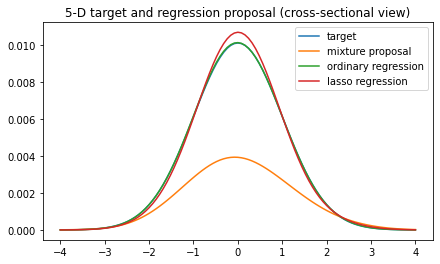

Reference:
origin: value: 8.3121; grad: (min -0.2775, mean -0.0137, max 0.2698, std 0.0562)

Theoretical results:
MLE(The) zeta: (min -0.2349, mean -0.0000, max 0.1585, std 0.0264, norm 0.8202)
theory: value: nan; grad: (min -5.2296, mean -0.0066, max 1.5397, std 0.2521)
RIS(The) est: 1.0005; err: 0.0005
MLE(The) est: 0.9914; err: 0.0086

Optimization results (spent 29 seconds):
MLE(Opt) zeta: (min -0.2107, mean 0.0000, max 0.1486, std 0.0254, norm 0.7878)
Dist(zeta(Opt),zeta(The))=0.1594
optimal: value: 8.2861; grad: (min -0.0000, mean -0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 1.0003; err: 0.0003
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
Reference:
origin: value: 8.3121; grad: (min -0.2775, mean -0.0137, max 0.2698, std 0.0562)

Theoretical results:
MLE(The) zeta: (min -0.2349, mean -0.0000, max 0.1585, std 0.0264, norm 0.8202)
theory: value: nan; grad: (min -5.2296, mean -0.0066, max 1.5397, std 0.2521)
RIS(The) est: 1.0005; err: 0.0005
MLE(The) est: 0.9914; err: 0

In [11]:
np.random.seed(1234)
mle=MLE(dim=5,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,100)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True,0)

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

mle.estimate_MLE(True,1)

**Summary:**
* Theoretical zeta is very close to optimal zeta, so we can use it as the initial guess for optimization. 
* Root finding for the gradient is far more efficient than maximization. 
* Theoretical RIS give exact same result as regression. 
* Theoretical MLE can achieve similar results as MLE based on optimization, so we can use it as an alternative method. 
* Theoretical MLE can't give exact result when target can be expressed by proposals, because its gradients are not small enough. 
* Sometimes (low-dimension, many kernels and small sample size? ) the theoretical zeta can be out of the feasible region, which indicates that the optimal zeta is very close to the boundary. 
* A bad theoretical zeta still is a good initial guess for optimization, which may result in infeasible but usable optimization result. 

**Future**
* Try more detailed experiments for MLE. 

## Regression and MLE only with kernels

IS est: 0.9448; err: 0.0552; a-var: 23.0217; a-err: 0.0339; ESS: 747/20000
------------ pdf ratio at origin: 256.00 ------------


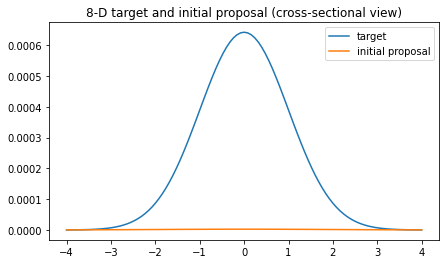

resampling rate: 427/500


In [16]:
np.random.seed(1234)
mle=MLE(dim=8,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(500,50)

### Control variables: $K_i(x)-q_0(x)$, $i\ge 1$

bdwth: 0.7982 (based on scott)
NIS est: 1.0001; err: 0.0001; a-var: 1.3666; a-err: 0.0083; ESS: 8452/20000
MIS est: 1.0054; err: 0.0054; a-var: 1.5742; a-err: 0.0089; ESS: 7821/20000
------------ pdf ratio at origin: 9.55 ------------


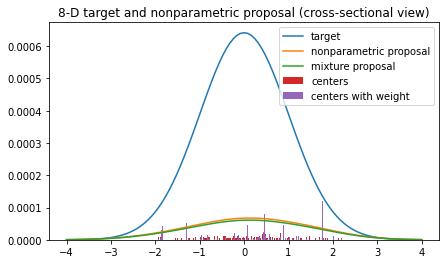

Condition index: (min 1.0000, median 5.9686, mean 6.3934, max 17.0403, [>30] 0/427)
Ordinary R2: 0.8278; Lasso R2: 0.8031
RIS(Ord) est: 0.9967; err: 0.0033; a-var: 0.2711; a-err: 0.0037; ESS: 15712/20000
RIS(Las) est: 0.9985; err: 0.0015; a-var: 0.3100; a-err: 0.0039; ESS: 15257/20000
------------ pdf ratio at origin: 10.57 ------------
regression ratios: ordinary 1.6754, lasso 1.8370


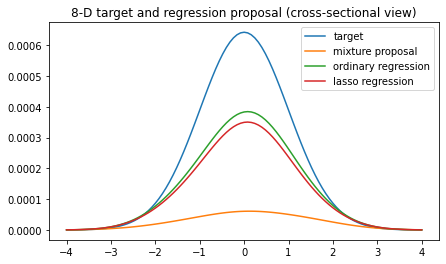

Reference:
origin: value: 13.7227; grad: (min -0.2551, mean -0.0163, max 0.3056, std 0.0804)

Theoretical results:
MLE(The) zeta: (min -0.0046, mean -0.0000, max 0.0031, std 0.0010, norm 0.0209)
theory: value: nan; grad: (min -0.5334, mean -0.0139, max 0.0155, std 0.0484)
RIS(The) est: 0.9967; err: 0.0033
MLE(The) est: 0.9914; err: 0.0086

Optimization results (spent 1 seconds):
MLE(Opt) zeta: (min -0.0038, mean 0.0000, max 0.0031, std 0.0010, norm 0.0200)
Dist(zeta(Opt),zeta(The))=0.0044
optimal: value: nan; grad: (min -0.0000, mean -0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 0.9951; err: 0.0049


In [17]:
np.random.seed(1997)
mle.estimate_NIS(size,0.9,reg=0)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)

### Control variables: $K_i(x)-K_1(x)$, $i\ge 2$

bdwth: 0.7982 (based on scott)
NIS est: 1.0001; err: 0.0001; a-var: 1.3666; a-err: 0.0083; ESS: 8452/20000
MIS est: 1.0054; err: 0.0054; a-var: 1.5742; a-err: 0.0089; ESS: 7821/20000
------------ pdf ratio at origin: 9.55 ------------


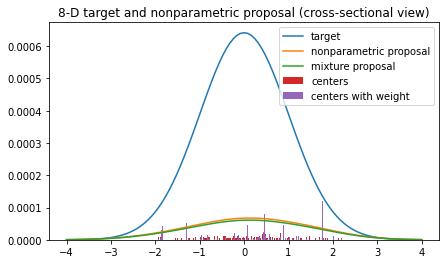

Condition index: (min 1.0000, median 18.6127, mean 21.5427, max 74.1022, [>30] 63/426)
Ordinary R2: 0.7947; Lasso R2: 0.7711
RIS(Ord) est: 0.9965; err: 0.0035; a-var: 0.3232; a-err: 0.0040; ESS: 15089/20000
RIS(Las) est: 0.9985; err: 0.0015; a-var: 0.3603; a-err: 0.0042; ESS: 14691/20000
------------ pdf ratio at origin: 10.57 ------------
regression ratios: ordinary 1.6787, lasso 1.8385


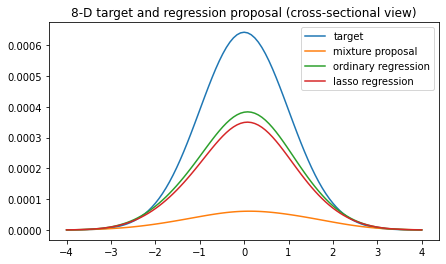

Reference:
origin: value: 13.7227; grad: (min -0.4190, mean -0.1806, max 0.1417, std 0.0801)

Theoretical results:
MLE(The) zeta: (min -0.0046, mean 0.0000, max 0.0031, std 0.0010, norm 0.0208)
theory: value: nan; grad: (min 0.1055, mean 0.5173, max 0.5454, std 0.0412)
RIS(The) est: 0.9965; err: 0.0035
MLE(The) est: 0.9911; err: 0.0089

Optimization results (spent 2 seconds):
MLE(Opt) zeta: (min -0.0038, mean 0.0000, max 0.0031, std 0.0010, norm 0.0198)
Dist(zeta(Opt),zeta(The))=0.0042
optimal: value: 13.7122; grad: (min 0.0000, mean 0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 0.9964; err: 0.0036


In [18]:
np.random.seed(1997)
mle.estimate_NIS(size,0.9,reg=1)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)

### Control variables: $K_i(x)-K_{i-1}(x)$, $i\ge 2$

bdwth: 0.7982 (based on scott)
NIS est: 1.0001; err: 0.0001; a-var: 1.3666; a-err: 0.0083; ESS: 8452/20000
MIS est: 1.0054; err: 0.0054; a-var: 1.5742; a-err: 0.0089; ESS: 7821/20000
------------ pdf ratio at origin: 9.55 ------------


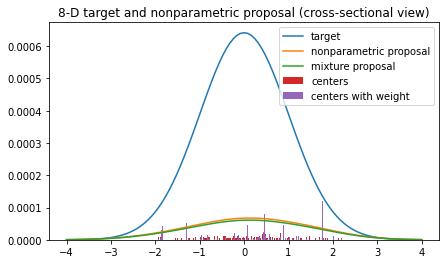

Condition index: (min 1.0000, median 2.4366, mean 10.2365, max 721.7766, [>30] 21/426)
Ordinary R2: 0.7947; Lasso R2: 0.6832
RIS(Ord) est: 0.9965; err: 0.0035; a-var: 0.3232; a-err: 0.0040; ESS: 15089/20000
RIS(Las) est: 0.9987; err: 0.0013; a-var: 0.4987; a-err: 0.0050; ESS: 13334/20000
------------ pdf ratio at origin: 10.57 ------------
regression ratios: ordinary 1.6787, lasso 2.2926


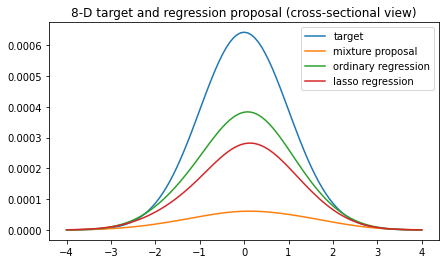

Reference:
origin: value: 13.7227; grad: (min -0.4176, mean -0.0001, max 0.4498, std 0.1144)

Theoretical results:
MLE(The) zeta: (min -0.0345, mean -0.0163, max 0.0044, std 0.0103, norm 0.3989)
theory: value: nan; grad: (min -0.4132, mean 0.0010, max 0.5180, std 0.0642)
RIS(The) est: 0.9965; err: 0.0035
MLE(The) est: 0.9911; err: 0.0089

Optimization results (spent 1 seconds):
MLE(Opt) zeta: (min -0.0347, mean -0.0165, max 0.0043, std 0.0098, norm 0.3953)
Dist(zeta(Opt),zeta(The))=0.0188
optimal: value: nan; grad: (min -0.0000, mean 0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 0.9962; err: 0.0038


In [19]:
np.random.seed(1997)
mle.estimate_NIS(size,0.9,reg=2)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)

### Control variables: $K_i(x)-\overline{K}(x)$, $i\ge 2$

bdwth: 0.7982 (based on scott)
NIS est: 1.0001; err: 0.0001; a-var: 1.3666; a-err: 0.0083; ESS: 8452/20000
MIS est: 1.0054; err: 0.0054; a-var: 1.5742; a-err: 0.0089; ESS: 7821/20000
------------ pdf ratio at origin: 9.55 ------------


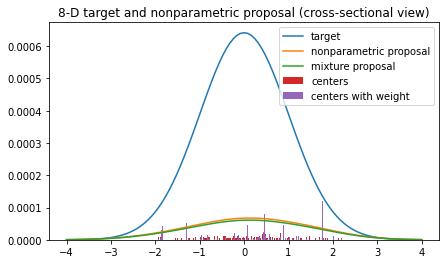

Condition index: (min 1.0000, median 2.3905, mean 2.6740, max 66.6433, [>30] 1/426)
Ordinary R2: 0.7947; Lasso R2: 0.7756
RIS(Ord) est: 0.9965; err: 0.0035; a-var: 0.3232; a-err: 0.0040; ESS: 15089/20000
RIS(Las) est: 0.9981; err: 0.0019; a-var: 0.3533; a-err: 0.0042; ESS: 14764/20000
------------ pdf ratio at origin: 10.57 ------------
regression ratios: ordinary 1.6787, lasso 1.7683


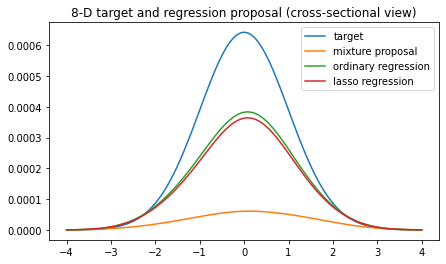

Reference:
origin: value: 13.7227; grad: (min -0.2388, mean -0.0004, max 0.3219, std 0.0801)

Theoretical results:
MLE(The) zeta: (min -0.0021, mean 0.0025, max 0.0056, std 0.0010, norm 0.0564)
theory: value: nan; grad: (min -0.4106, mean 0.0012, max 0.0293, std 0.0412)
RIS(The) est: 0.9965; err: 0.0035
MLE(The) est: 0.9911; err: 0.0089

Optimization results (spent 1 seconds):
MLE(Opt) zeta: (min -0.0021, mean 0.0016, max 0.0047, std 0.0010, norm 0.0389)
Dist(zeta(Opt),zeta(The))=0.0195
optimal: value: nan; grad: (min -0.0000, mean -0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 0.9962; err: 0.0038


In [20]:
np.random.seed(1997)
mle.estimate_NIS(size,0.9,reg=3)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)

**Summary:**
* All workable but worse. 
* Type 1 and 2 has big correlation. 
* Different type give same result. 

**Future:**
* What about completely different kernels? 